In [1]:
import pandas as pd
import numpy as np
from meteostat import Point, Monthly
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Download temperature data for Missoula
start = datetime(1999, 10, 1)
end = datetime(2023, 9, 30)
mso = Point(46.86890938888096, -113.99148295276562, 1100)
data = Monthly(mso, start, end)
df_tavg = data.fetch()['tavg']

# Bring in population data and resample to monthly
df_pop = pd.read_csv('../data/mso_pop_year_full.csv', index_col=0)
df_pop.index = pd.to_datetime(df_pop.index, format="%Y")
df_pop = df_pop['population'].resample('MS').mean().interpolate()[start:end]

# Bring City pumping rates
df_dem = pd.read_csv('../data/mso_monthly_pumping_rates.csv')
df_dem['yrmo'] = pd.to_datetime(df_dem['yrmo'], format="%b %Y")
df_dem.set_index('yrmo', inplace=True)
df_dem = df_dem['vol_Mg'][start:end]

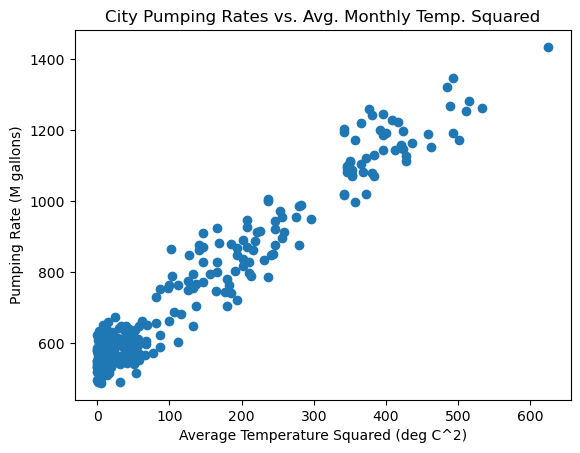

In [12]:
plt.scatter(df_tavg.values**2, df_dem.values)
plt.xlabel('Average Temperature Squared (deg C^2)')
plt.ylabel('Pumping Rate (M gallons)')
plt.title('City Pumping Rates vs. Avg. Monthly Temp. Squared')
plt.show()

### OLS model

In [16]:
# x = df_tavg.values**2
x = np.column_stack((df_pop.values, df_tavg.values**2))
x = sm.add_constant(x)
y = df_dem.values

In [17]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2538.
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          2.45e-182
Time:                        07:34:17   Log-Likelihood:                -1551.3
No. Observations:                 288   AIC:                             3109.
Df Residuals:                     285   BIC:                             3120.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        473.7880     35.409     13.381      0.000     404.092     543.484
x1             0.0011      0.001      2.112      0.036    7.42e-05       0.002
x2             1.4907      0.021     70.881      0.000       1.449       1.532
==============================================================================
Omnibus:                        6.820   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.709
Skew:                           0.316   Prob(JB):                       0.0349
Kurtosis:                       3.399   Cond. No.                     7.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

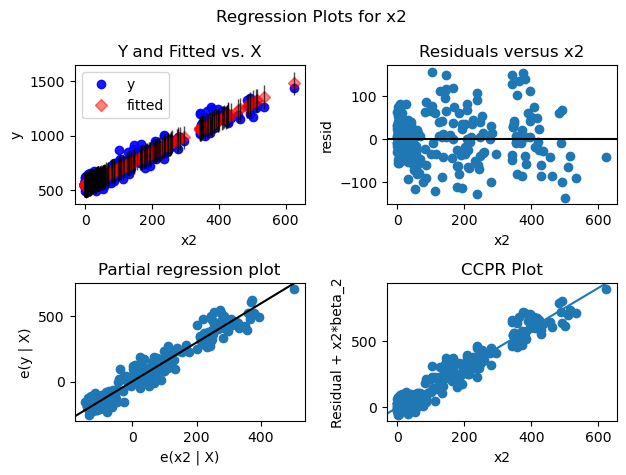

In [8]:
fig = sm.graphics.plot_regress_exog(model, 'x2')
fig.tight_layout()